# Named Entity Recognition Using BERT

In [ ]:
# About Classes
class Building:
     def __init__(self, floors):
         self._floors = [None]*floors
     def __setitem__(self, floor_number, data):
          self._floors[floor_number] = data
     def __getitem__(self, floor_number):
          return self._floors[floor_number]

building1 = Building(4) # Construct a building with 4 floors
building1[0] = 'Reception'
building1[1] = 'ABC Corp'
building1[2] = 'DEF Inc'
print( building1[2] )

https://www.kaggle.com/jonofields/bert-ner-sentence


https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

### 3 Types of Contextualized Word Embeddings From BERT Using Transfer Learning
A tutorial to extract contextualized word embeddings from BERT using python, pytorch, and pytorch-transformers to get three types of contextualized representations.


https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d

#### Data Link:  
https://www.kaggle.com/jonofields/bert-ner-sentence

## Import Libraries

In [ ]:
# !pip install transformers==2.6.0
# !pip install seqeval

In [31]:
import numpy as np 
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from tqdm import tqdm, trange
from seqeval.metrics import f1_score, accuracy_score

torch.__version__

'1.10.2+cu102'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.device_count())

1


### Import Data

In [3]:
GOOGLE_COLAB = False # Ran on Lab Clusters
if GOOGLE_COLAB:
    data = pd.read_csv('/content/NER_Dataset.csv', encoding='latin1')
else: 
    data = pd.read_csv('./NER_Dataset.csv', encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### Prepare Data Into List of Sentences an NER Tags

In [5]:
class DataPreparation:
  def __init__(self, data):
    self.data = data
    agg_function = lambda s: [(w, p, s) for w, p, s in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
    
    self.group = self.data.groupby('Sentence #').apply(agg_function)
    self.sentence = [s for s in self.group]

  def retrieveItems(self,):
    sentence = [[word[0] for word in sentence] for sentence in self.sentence]
    labels = [[lab[2] for lab in sentence] for sentence in self.sentence]
    tag_values = list(set(data["Tag"].values))
    tag_values.append('PAD') # Assigning Id for Pad
    tag_idx = {t: i for i, t in enumerate(tag_values)}
    
    self.printExamples(sentence, labels, tag_values, tag_idx)
    
    return sentence, labels, tag_values, tag_idx
      
  def printExamples(self, s, l, t_v, t_i):
    print(s[0])
    print(l[0])
    print(t_v)
    print(t_i)

In [6]:
dataPrep = DataPreparation(data)
sentences, labels, tag_values, tag_idx = dataPrep.retrieveItems()

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
['O', 'B-per', 'I-eve', 'B-tim', 'I-per', 'B-eve', 'I-geo', 'B-org', 'I-tim', 'I-gpe', 'B-art', 'I-art', 'B-geo', 'B-gpe', 'I-org', 'B-nat', 'I-nat', 'PAD']
{'O': 0, 'B-per': 1, 'I-eve': 2, 'B-tim': 3, 'I-per': 4, 'B-eve': 5, 'I-geo': 6, 'B-org': 7, 'I-tim': 8, 'I-gpe': 9, 'B-art': 10, 'I-art': 11, 'B-geo': 12, 'B-gpe': 13, 'I-org': 14, 'B-nat': 15, 'I-nat': 16, 'PAD': 17}


In [69]:
allLabels = []
for l in labels:
    allLabels.extend(l)
freqList = Counter(allLabels).most_common()
freqList

[('O', 887908),
 ('B-geo', 37644),
 ('B-tim', 20333),
 ('B-org', 20143),
 ('I-per', 17251),
 ('B-per', 16990),
 ('I-org', 16784),
 ('B-gpe', 15870),
 ('I-geo', 7414),
 ('I-tim', 6528),
 ('B-art', 402),
 ('B-eve', 308),
 ('I-art', 297),
 ('I-eve', 253),
 ('B-nat', 201),
 ('I-gpe', 198),
 ('I-nat', 51)]

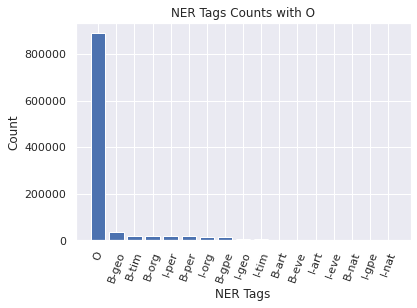

In [70]:
count = list(zip(*freqList))[1]
NERTags = list(zip(*freqList))[0]
x_pos = np.arange(len(freqList))
plt.bar(x_pos, count,align='center')
plt.xticks(x_pos, NERTags, rotation=70) 
plt.ylabel('Count')
plt.xlabel('NER Tags')
plt.title('NER Tags Counts with O')
plt.show()

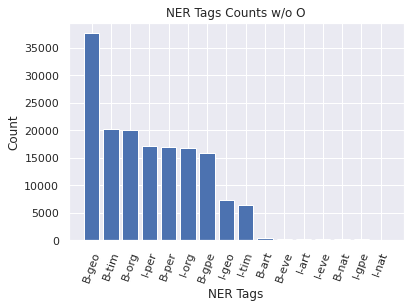

In [71]:

freqList = freqList[1:]
count = list(zip(*freqList))[1]
NERTags = list(zip(*freqList))[0]
x_pos = np.arange(len(freqList))
plt.bar(x_pos, count,align='center')
plt.title('NER Tags Counts w/o O')
plt.xticks(x_pos, NERTags, rotation=70) 
plt.ylabel('Count')
plt.xlabel('NER Tags')
plt.show()

In [7]:
print('First Sentence Length: {}'.format(len(sentences[0])))
print('Total Sentences: {}'.format(len(sentences)))

First Sentence Length: 24
Total Sentences: 47959


### Process Data for Model

In [8]:
# Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

In [9]:
HYPER_PARAMETERS = {
    "MAX_LEN" : 75, # Max Length of the sentence
    "BATCH_SIZE" : 16,

    "EPOCHS" : 3,
    "MAX_GRAD_NORM" : 1.0,

    "LEARNING_RATE" : 3e-5,
    "EPSILON" : 1e-8
}

In [10]:
class DataProcessing:
  def __init__(self, sentences, text_labels, HYPER_PARAMETERS):
    self.sentences = sentences
    self.text_labels = text_labels
    self.HYPER_PARAMETERS = HYPER_PARAMETERS

    # List of tuples of tokenized sentences
    self.tokenized_texts_and_labels = [self.tokenize_preserve(sent,labs) for sent,labs in zip(self.sentences,self.text_labels)]
    # Seperates tokenized pairs into labels and tokens
    self.tokenized_text = [token_label_pair[0] for token_label_pair in self.tokenized_texts_and_labels]
    self.labels = [token_label_pair[1] for token_label_pair in self.tokenized_texts_and_labels] 

  def tokenize_preserve(self,sent,labs):
    tokenized_sentence = []
    labels = []
    
    for word, label in zip(sent,labs):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)
    
    return tokenized_sentence, labels

  def getProcessedData(self,):
    input_ids = pad_sequences(
                          [tokenizer.convert_tokens_to_ids(txt) for txt in self.tokenized_text], # converts tokens to ids
                         maxlen= self.HYPER_PARAMETERS['MAX_LEN'], dtype='long',value=0.0,
                         truncating='post',padding='post')
    tags = pad_sequences(
                    [[tag_idx.get(l)for l in lab]for lab in self.labels], # Gets corresponding tag_id
                    maxlen= self.HYPER_PARAMETERS['MAX_LEN'], dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')
    
    attention_masks = [[float(i !=0.0) for i in ii]for ii in input_ids] # Float(True) = 1.0 for attention for only non-padded inputs
    
    self.printOutputs(input_ids, tags, attention_masks)

    return input_ids, tags, attention_masks

  def printOutputs(self,input_ids, tags, attention_masks):
    print('Inputs: {}'.format(input_ids[0]))
    print('Tags: {}'.format(tags[0]))
    print('Attention Mask: {}'.format(attention_masks[0]))
    print('Lengths Matching: {}, {}, {}'.format(len(input_ids[0]), len(tags[0]), len(attention_masks[0])))

In [11]:
dataProc = DataProcessing(sentences, labels, HYPER_PARAMETERS)
input_ids, tags, attention_masks = dataProc.getProcessedData()

Inputs: [26159  1104  8568  4487  5067  1138  9639  1194  1498  1106  5641  1103
  1594  1107  5008  1105  4555  1103 10602  1104  1418  2830  1121  1115
  1583   119     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Tags: [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0 12  0  0  0  0  0 13  0  0  0
  0  0 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17]
Attention Mask: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [12]:
print('Input Matrices Shape: {}'.format(input_ids.shape))

Input Matrices Shape: (47959, 75)


### Test Train Split

In [13]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.15) # Get Train Test Split for Inputs and Tags
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.15) # Get Split for NER

In [14]:
print('Input Train Size: {}, {}, {}:'.format(len(tr_masks),len(tr_input), len(tr_tag)))
print('Input Val Size: {}, {}, {}:'.format(len(val_masks),len(val_input), len(val_tag)))

Input Train Size: 40765, 40765, 40765:
Input Val Size: 7194, 7194, 7194:


In [15]:
# Converting to type tensor
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)

tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

### DataLoader

In [16]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_data

In [17]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=HYPER_PARAMETERS['BATCH_SIZE'])

valid_data = TensorDataset(val_input, val_masks, val_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=HYPER_PARAMETERS['BATCH_SIZE'])

In [18]:
model = BertForTokenClassification.from_pretrained( # Getting BERT's pretrained Token Classification model
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

In [19]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# list(model.named_parameters())

In [20]:
FULL_FINETUNING = True
if FULL_FINETUNING: # Fine Tuning
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], # Setting Weight Decay Rate 0.01 if it isnt bias, gamma and beta
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], # If it is set to 0.0
         'weight_decay_rate': 0.0}
    ]
else: # Non Fine Tuning
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]


# Optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= HYPER_PARAMETERS['LEARNING_RATE'],
    eps= HYPER_PARAMETERS['EPSILON']
)

In [21]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * HYPER_PARAMETERS['EPOCHS']

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [22]:
vars(train_dataloader)

{'dataset': <torch.utils.data.dataset.TensorDataset at 0x7ff92121cdc0>,
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 16,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7ff92121c130>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7ff92121cf70>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [23]:
import warnings
warnings.filterwarnings("ignore")

## Traing and Validation

In [24]:
loss_values, validation_loss_values = [], []
E = 1
for _ in trange(HYPER_PARAMETERS['EPOCHS'], desc= "Epoch \n"):
    print('\n')
    print('Epoch #{}'.format(E))
  
    start = time.time()

    model.train()
    total_loss=0 # Reset at each Epoch
    
    ###################### TRAINING
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch # Mantained the order for both train_data/val_data
        
        model.zero_grad() # Clearing previous gradients for each epoch
        
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels) # Forward pass
        
        loss = outputs[0]
        loss.backward() # Getting the loss and performing backward pass
        
        total_loss += loss.item() # Tracking loss
        
        # Preventing exploding grads
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=HYPER_PARAMETERS['MAX_GRAD_NORM'])
        
        optimizer.step() # Updates parameters
        scheduler.step() # Update learning_rate
        
    avg_train_loss = total_loss/len(train_dataloader) 
    print('Average Train Loss For Epoch {}: {}'.format(E, avg_train_loss))
    
    loss_values.append(avg_train_loss) # Storing loss values to plot learning curve
    
    ###################### VALIDATION
    model.eval()
    
    eval_loss = 0
    predictions, true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad(): # No backprop
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy() # Getting Probabilities for Prediction Classes
        label_ids = b_labels.to('cpu').numpy() # Golden Labels
        
        loss = outputs[0]
        eval_loss += loss.item()

        predictions.extend([list(p) for p in np.argmax(logits, axis=2)]) # Taking Max among Prediction Classes
        true_labels.extend(label_ids)

    avg_eval_loss = eval_loss / len(valid_dataloader)
    print('Average Val Loss For Epoch {}: {}'.format(E, avg_eval_loss))

    validation_loss_values.append(avg_eval_loss)
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']
    
    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']
    
    print('Validation Accuracy: {}%'.format(accuracy_score(pred_tags,valid_tags)*100))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))

    stop = time.time()
    print('Epoch #{} Duration:{}'.format(E, stop-start))
    E+=1
    print('-'*20)
    time.sleep(3)

Epoch 
:   0%|          | 0/3 [00:00<?, ?it/s]



Epoch #1
Average Train Loss For Epoch 1: 0.17885337665010378
Average Val Loss For Epoch 1: 0.13307458280689186
Validation Accuracy: 95.79076780585157%
Validation F-1 Score:0.8151456704903055
Epoch #1 Duration:246.94444036483765
--------------------


Epoch 
:  33%|███▎      | 1/3 [04:09<08:19, 249.95s/it]



Epoch #2
Average Train Loss For Epoch 2: 0.10371701116381239
Average Val Loss For Epoch 2: 0.1274025301531785
Validation Accuracy: 96.16290031810438%
Validation F-1 Score:0.83037071569005
Epoch #2 Duration:249.1318838596344
--------------------


Epoch 
:  67%|██████▋   | 2/3 [08:22<04:11, 251.24s/it]



Epoch #3
Average Train Loss For Epoch 3: 0.07242823120066239
Average Val Loss For Epoch 3: 0.1345602497872379
Validation Accuracy: 96.2968680225154%
Validation F-1 Score:0.8384581195199806
Epoch #3 Duration:248.76845359802246
--------------------


Epoch 
Epoch |██████████| 3/3 [12:33<00:00, 251.48s/it]
: 100%|██████████| 3/3 [12:33<00:00, 251.29s/it]


### Plotting Traing vs Validation Loss

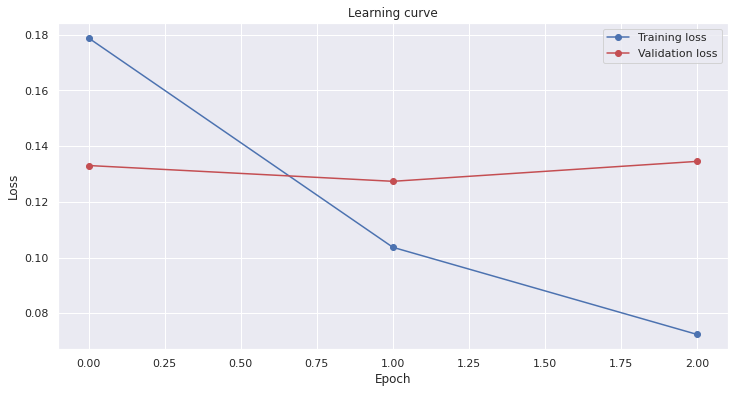

In [25]:
# Plot Training vs Validation Loss
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="Training loss")
plt.plot(validation_loss_values, 'r-o', label="Validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Test on a single example

In [26]:
test_sentence = """Hello, my name is Jonathan and I live in Chicago along with my girlfriend Paige and my dog Goose.
Paige and myself are interested in moving to North Carolina, Tennessee, Washington, or Colorado if we get the opportunity.
I hope to work as a data scientist, and Paige wants to be the Hokage of the Hidden Leaf Village."""

In [27]:
tokenized_sentence = tokenizer.encode(test_sentence) # Encode sentence with BERT tokenizer
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [28]:
with torch.no_grad(): # Forward Pass without Backprop
    output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [29]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [30]:
for token, label in zip(new_tokens, new_labels): # Showing labels against the words
    print('{}\t{}'.format(label,token))

O	[CLS]
O	Hello
O	,
O	my
O	name
O	is
B-per	Jonathan
O	and
O	I
O	live
O	in
B-geo	Chicago
O	along
O	with
O	my
O	girlfriend
B-per	Paige
O	and
O	my
O	dog
O	Goose
O	.
B-per	Paige
O	and
O	myself
O	are
O	interested
O	in
O	moving
O	to
B-geo	North
I-geo	Carolina
O	,
B-geo	Tennessee
O	,
B-geo	Washington
O	,
O	or
B-geo	Colorado
O	if
O	we
O	get
O	the
O	opportunity
O	.
O	I
O	hope
O	to
O	work
O	as
O	a
O	data
O	scientist
O	,
O	and
B-per	Paige
O	wants
O	to
O	be
O	the
O	Hokage
O	of
O	the
B-org	Hidden
I-org	Leaf
I-org	Village
O	.
O	[SEP]


### Experimental Validation, Insights and Discussion of Results 

We used BERT's tokenizer to tokenize our words and then used BERT's classification model to get the NER Tag classes for each word. There were a total of 47959 sentences where we used a 15% train-test split with 40765 training examples and 7194 validation examples. We obtained the dataset from Kaggle which has the link shown above. From the loss graph above we can see our training loss decrreasing after 3 epochs whereas the validation loss stays more or less constant. We can infer from this that one eoch woud have also been enough to train the BERT Classifcation model on this data. We further see that we get a final validation accuracy of 96% and F1-Score of 0.83 which shows a great performance and that even though the classes of NER Tags were imbalanced the F1-Score as it combines the Precision and Recall shows a healthy score.